In [43]:
import torch, sys, os, numpy as np, pandas as pd, optuna, ast
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

from classy_vision.generic.util import load_checkpoint
from classy_vision.models import ClassyModel, build_model

from scipy.stats import differential_entropy, skew, kurtosis

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, balanced_accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from skimage import io
from umap import UMAP
from sklearn.decomposition import PCA

import albumentations as A
from albumentations.pytorch import ToTensorV2

from matplotlib import pyplot as plt

## Specify Any Helper Functions
- embedding function that takes an encoder and dataloader and outputs embeddings

In [2]:
def create_embedding(encoder, full_loader, device):
    """
    Creates embedding using encoder from dataloader.
    encoder: A convolutional Encoder.
    full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
    device: "cuda" or "cpu"
    Returns: Embedding of size (num_images_in_loader, embeddingu_dim)
    """
    # Set encoder to eval mode.
    encoder.eval()
    
    embedding = []
    
    #we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, data in enumerate(full_loader):
            # We can compute this on GPU
            train_img = data['image'].to(device)
            
            # Get encoder outputs and move outputs to cpu
            enc_output = encoder(train_img).cpu().detach().numpy()
            # Keep adding these outputs to embeddings.
            embedding = embedding + [{'label':data['label'][i], 'user':data['user'][i],'img_name':data['img_name'][i], 'embedding':enc_output[i,:]} for i in range(len(data['img_name']))]
    
    # Return the embeddings
    return embedding

## Set hyperparameters

In [3]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size= 24
image_size = (512, 512)

## Create the data set
- create data set loaders
- create augmentation pipelines for the images
- visualize a few examples

In [44]:
class PhoMemesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        locations = []
        for i in os.listdir(root_dir):
            for j in os.listdir(os.path.join(root_dir,i)):
                for k in os.listdir(os.path.join(root_dir,i,j)):
                    locations.append([i,j,k])
        self.locations = locations
        self.root_dir =root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.locations)
    
    def preprocess_image(self, image):
        # Convert images to RGB format
        if image.ndim <3:
            image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        elif image.shape[-1] ==4:
            rgb = np.zeros( (image.shape[0], image.shape[1], 3), dtype='float32' )
            r, g, b, a = image[:,:,0], image[:,:,1], image[:,:,2], image[:,:,3]
            a = np.asarray( a, dtype='float32' ) / 255.0
            R, G, B = (255,255,255) 
            rgb[:,:,0] = r * a + (1.0 - a) * R
            rgb[:,:,1] = g * a + (1.0 - a) * G
            rgb[:,:,2] = b * a + (1.0 - a) * B
            image = np.asarray( rgb, dtype='uint8' )
        return image
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.locations[index][0], self.locations[index][1], self.locations[index][2])
        image = io.imread(img_path)
        image = self.preprocess_image(image)

        if self.transform is not None:
            # uncomment for use with albumentations transforms
            augmentations = self.transform(image=image)
            image = augmentations["image"]

            # uncomment for use with torchvision transforms
            #image = self.transform(image)

        return {'image':image, 'label':self.locations[index][0], 'user':self.locations[index][1], 'img_name':self.locations[index][2]}

In [45]:
'''
for transforms, just place the images into the same dimensions and 
scale them to what the model expects in terms of tensor values
'''
transforms = A.Compose([
    A.Resize(image_size[0], image_size[1]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
    ])

In [50]:
dataset = PhoMemesDataset(root_dir="training", transform=transforms)
example_loader = DataLoader(dataset=dataset, batch_size=8, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


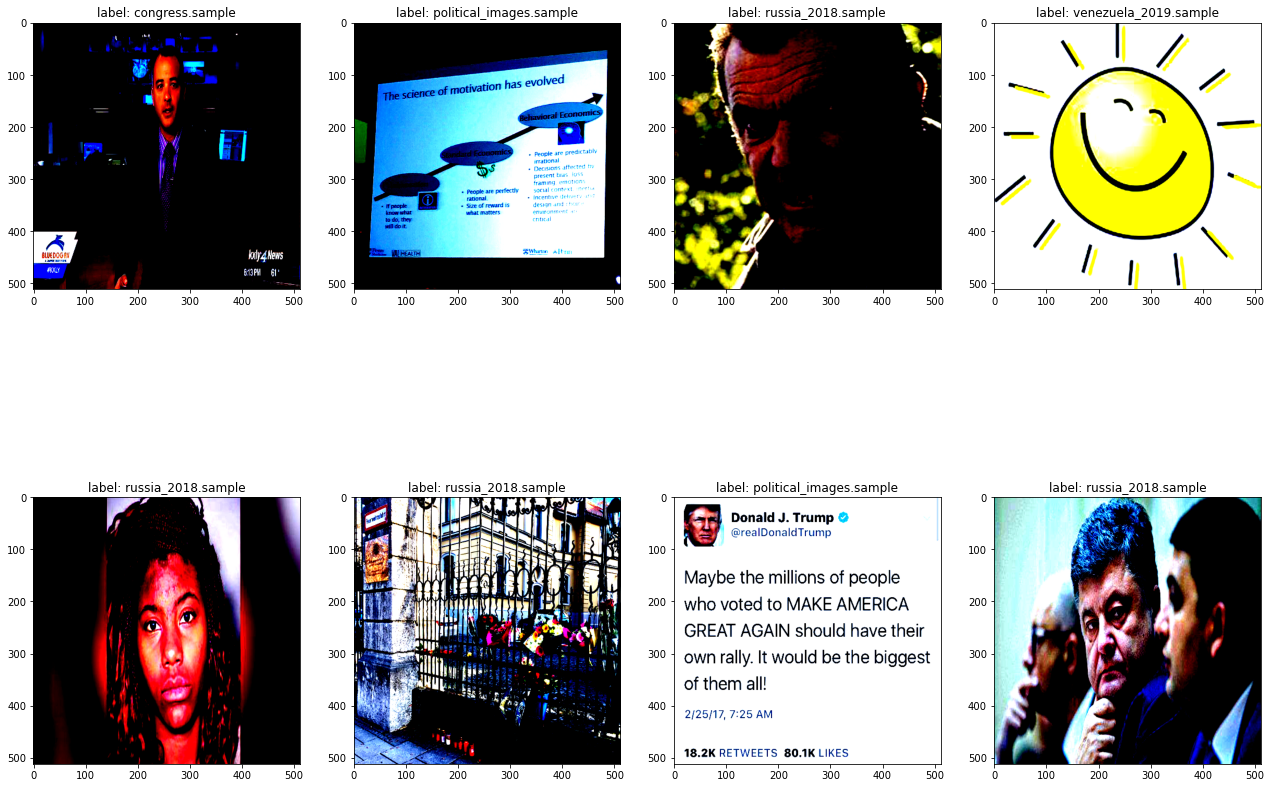

In [51]:
# Look at some example images
batch = next(iter(example_loader))

f, axarr = plt.subplots(2,4, figsize=(22,16))
counter = 0
for i in range(2):
    for j in range(4):
        tensor_image = batch['image'][counter]
        axarr[i,j].imshow(tensor_image.permute(1, 2, 0) )
        axarr[i,j].title.set_text("label: {}".format(batch['label'][counter]))
        counter+=1

## Specify the Image Embedding Model
- Specify the embedding model
    - try a readily-available model pre-trained on an indeuction task
    - try a avant garde self-trained model to produce the embeddings

In [52]:
class Embedding_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(torchvision.models.efficientnet_b7(pretrained=True).features,
                      nn.AdaptiveAvgPool2d(output_size=1)
                     )
        '''
        model = torchvision.models.regnet_y_32gf()
        classy_model = ClassyModel.from_model(model)
        state = classy_model.get_classy_state("seer_regnet32gf_model_iteration244000.torch")
        classy_model.set_classy_state(state)
        self.model = nn.Sequential(*list(classy_model.model.children())[:-1])
        '''

    def forward(self, x):
        x = torch.squeeze(self.model(x))
        return x

In [53]:
encoder = Embedding_Model().to(device)

## Create Embeddings for the Images
- create embddings for the train and test datasets

In [54]:
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
embedding_df = pd.DataFrame(create_embedding(encoder, train_loader, device))

In [55]:
embedding_df.shape

(5223, 4)

In [56]:
# Read in the test data and create embeddings for all of the images

test_dataset = PhoMemesDataset(root_dir="test", transform=transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
test_embedding_df = pd.DataFrame(create_embedding(encoder, test_loader, device))

In [57]:
test_embedding_df.shape

(41899, 4)

In [58]:
all_embedding_df = pd.concat([embedding_df, test_embedding_df])

In [59]:
all_embedding_df.shape

(47122, 4)

## Visualize the Image Embeddings
- visualize images in 2-D reduced dimensionality, colored by the campiagns they come from
- visualize images in 2-D reduced dimensionality, refined by users, colored by the campaigns they come from
- visualize individual user's images

In [245]:
mapper = UMAP(n_components=2, n_neighbors=15)
mapper.fit(np.stack(all_embedding_df['embedding'].values))
reduced_dim = mapper.transform(np.stack(embedding_df['embedding'].values))

Z:\Users\Iain\Anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [246]:
embedding_df['reduced_embedding']= reduced_dim.tolist()

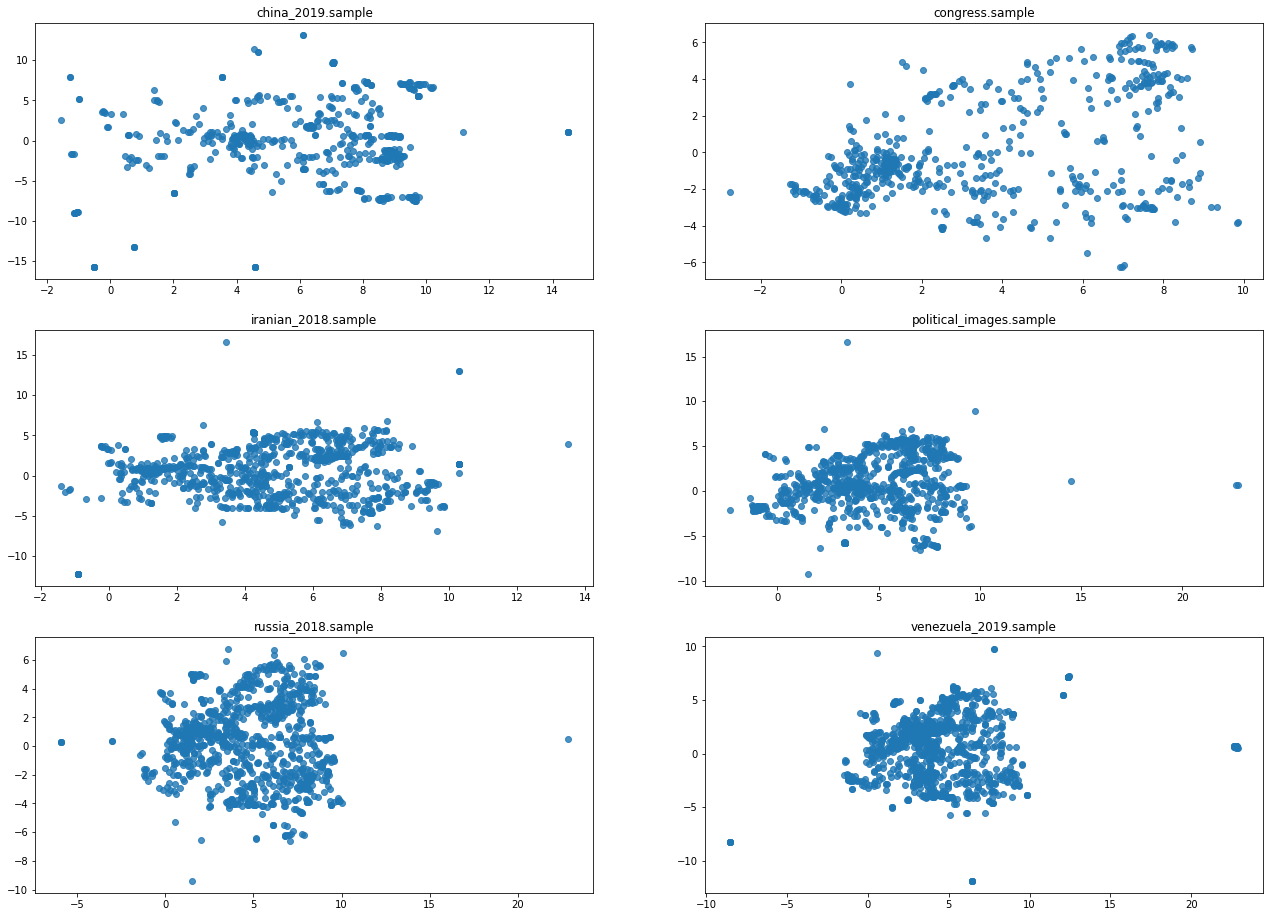

In [247]:
fig, axes = plt.subplots(3,2, figsize=(22, 16))

counter = 0
labels = embedding_df['label'].unique()
for i in range(3):
    for j in range(2):   
        g = labels[counter]
        ix = np.where(embedding_df['label'] == g)
        axes[i,j].scatter(reduced_dim[ix,0], reduced_dim[ix,1], label = g, alpha =0.8)
        axes[i,j].set_title(str(g))
        counter += 1
    
plt.show()

Now, looking at the user level for visualization

In [248]:
user_embedding_df = pd.DataFrame(embedding_df[['user', 'embedding', 'reduced_embedding']].groupby('user').agg(np.stack))
user_embedding_df = user_embedding_df.merge(embedding_df[['user', 'label']], how="left", left_on="user", right_on="user")

In [249]:
# just taking an average across all images for each useru
user_embedding_df['user_embedding'] = user_embedding_df['embedding'].apply(lambda x: np.mean(x, axis=0)) 

In [253]:
user_mapper = UMAP(n_components=2, n_neighbors=20)
user_reduced_dim = mapper.fit_transform(np.stack(user_embedding_df['user_embedding'].values))

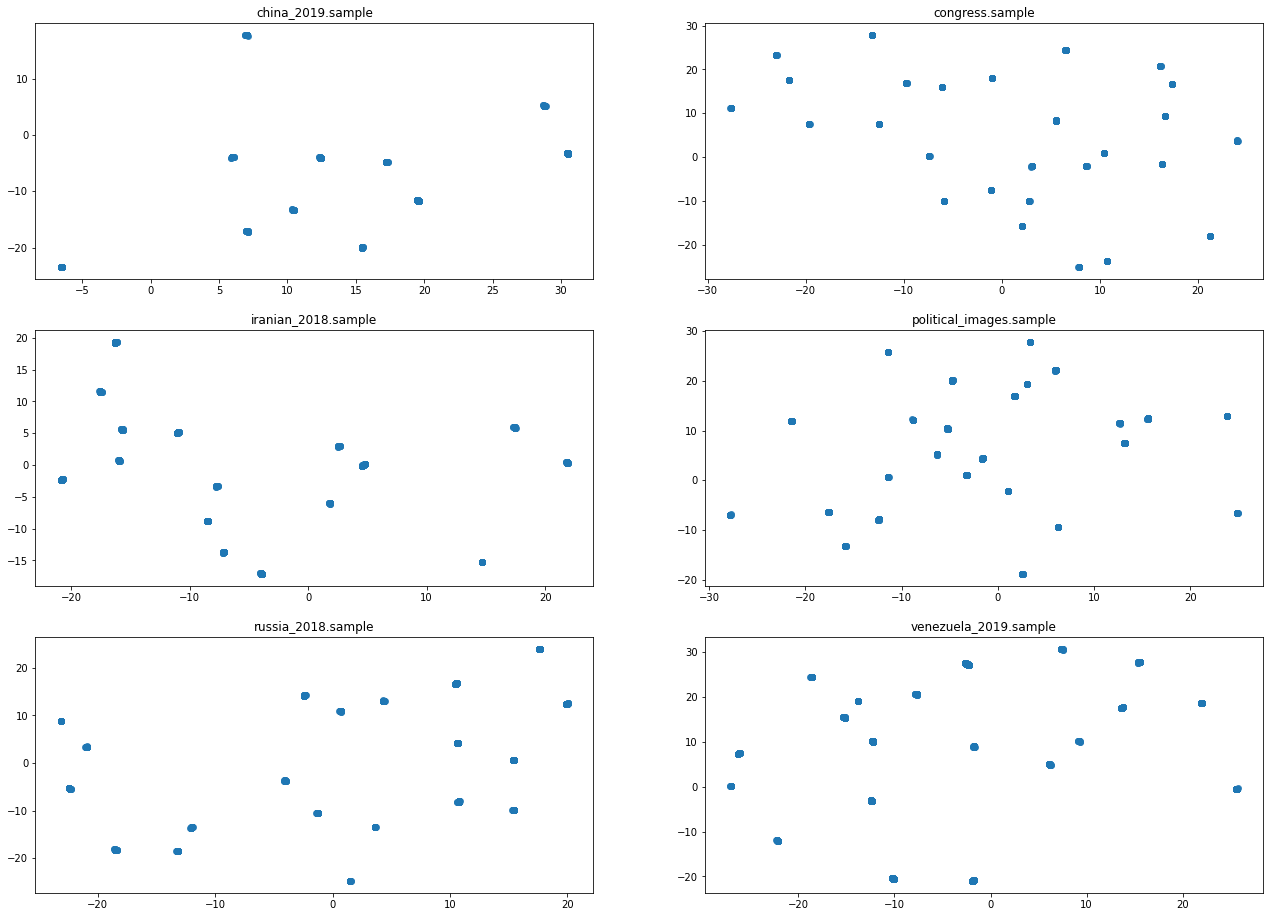

In [254]:
fig, axes = plt.subplots(3,2, figsize=(22, 16))

counter = 0
labels = embedding_df['label'].unique()
for i in range(3):
    for j in range(2):   
        g = labels[counter]
        ix = np.where(user_embedding_df['label'] == g)
        axes[i,j].scatter(user_reduced_dim[ix,0], user_reduced_dim[ix,1], label = g, alpha =0.8)
        axes[i,j].set_title(str(g))
        counter += 1
    
plt.show()

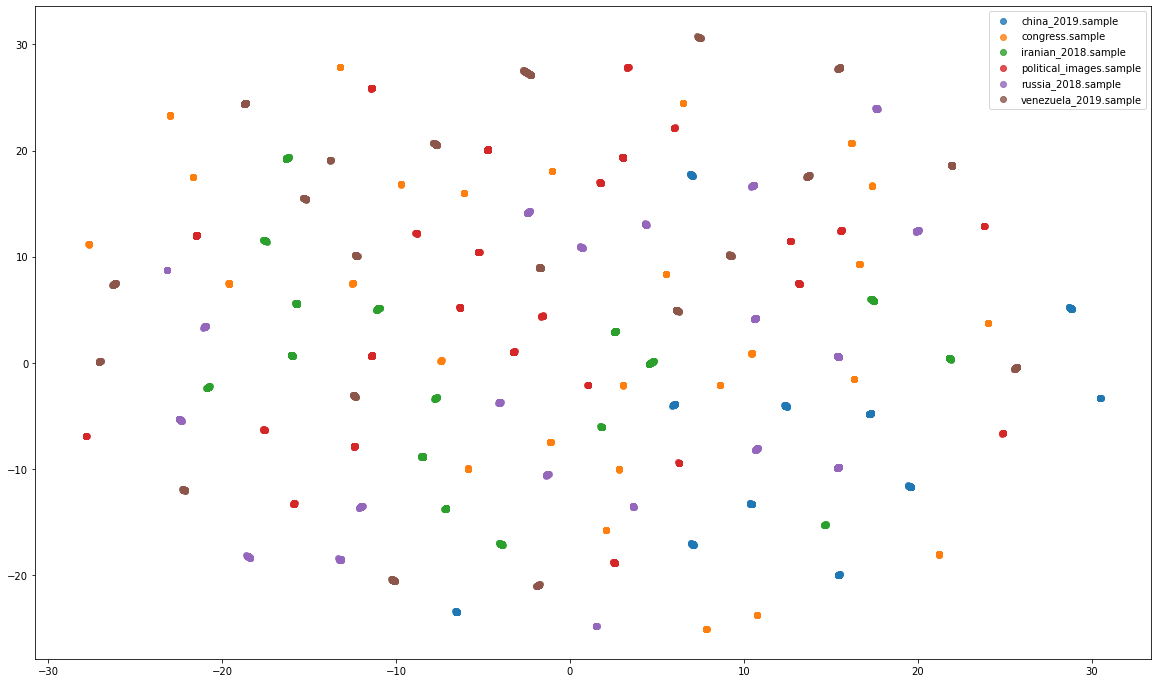

In [255]:
fig, ax = plt.subplots(figsize=(20, 12))
for g in embedding_df['label'].unique():
    ix = np.where(user_embedding_df['label'] == g)
    ax.scatter(user_reduced_dim[ix,0], user_reduced_dim[ix,1], label = g, alpha =0.8)
    
ax.legend()
plt.show()

Now, visualize images for different individual users

In [256]:
country_labels = user_embedding_df['label'].unique()

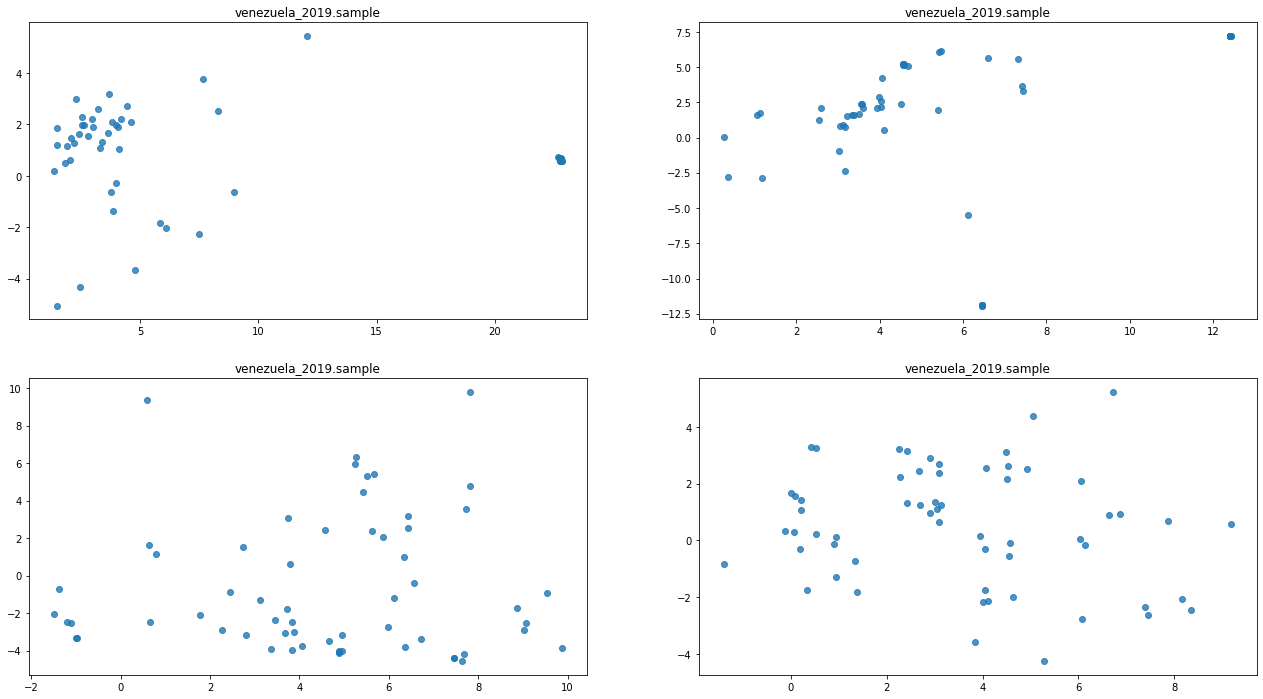

In [263]:
label = 0

fig, axes = plt.subplots(2,2, figsize=(22, 12))
df = user_embedding_df[user_embedding_df['label']==country_labels[label]]
users = np.random.choice(df['user'].unique(), size=6, replace=False)

counter = 0
for i in range(2):
    for j in range(2):   
        embeddings = df[df['user']==users[counter]]['reduced_embedding'].values[0]
        axes[i,j].scatter(embeddings[:,0], embeddings[:,1], label = country_labels[label], alpha =0.8)
        axes[i,j].set_title(str(country_labels[label]))
        counter += 1
    
plt.show()

## Featurize the Data for a Predictive Model
- get distribution statistics for each user, based on their photo embeddings

In [164]:
# I chose to reduce dimensionality since there are relatively few examples

training_mapper = UMAP(n_components=15, n_neighbors=15)
training_mapper.fit(np.stack(all_embedding_df['embedding'].values))
training_dim = training_mapper.transform(np.stack(embedding_df['embedding'].values))

Z:\Users\Iain\Anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [165]:
# Add in clustrer features ala https://arxiv.org/pdf/2110.01183.pdf

cluster_featurizer = KMeans(n_clusters=10, n_init=10)
cluster_featurizer.fit(np.stack(all_embedding_df['embedding'].values))
training_clusters = cluster_featurizer.predict(np.stack(embedding_df['embedding'].values))

In [166]:
embedding_df['training_dim']= training_dim.tolist()
embedding_df['cluster_assignment'] = training_clusters
cluster_df = pd.crosstab(embedding_df['user'], embedding_df['cluster_assignment'])
train_df = pd.DataFrame(embedding_df[['user', 'training_dim']].groupby('user').agg(np.stack))
train_df = train_df.merge(embedding_df[['user', 'label']], how="left", left_on="user", right_on="user")
train_df = train_df.groupby('user').first().reset_index()
train_df = train_df.merge(cluster_df, how="left", left_on="user", right_on="user")

In [167]:
# Create the distribution based features

train_df['mean'] = train_df['training_dim'].apply(lambda x : np.mean(x, axis=0))
train_df['std'] = train_df['training_dim'].apply(lambda x : np.std(x, axis=0))
train_df['skew'] = train_df['training_dim'].apply(lambda x : skew(x))
train_df['kurtosis'] = train_df['training_dim'].apply(lambda x : kurtosis(x))
train_df['diff_entropy'] = train_df['training_dim'].apply(lambda x : differential_entropy(x))
train_df['outlier_scores'] = train_df['training_dim'].apply(lambda x: LocalOutlierFactor(n_neighbors=5).fit_predict(x))
train_df['inlier_ratio'] = train_df['outlier_scores'].apply(lambda x: np.sum(x==1)/len(x))

# make the target variable a categorical
train_df['label']= train_df['label'].astype('category')

In [168]:
campaign_codes = dict( enumerate(train_df['label'].cat.categories ) )

In [169]:
X = train_df[['mean', 'std', 'skew', 'kurtosis', 'diff_entropy']]
X = np.array([np.concatenate(i) for i in X.values.tolist()])
X = np.concatenate([X, train_df[[0,1,2,3,4,5,6,7,8,9]]], axis=1)
#X = np.append(X, np.array(train_df['inlier_ratio'].values, copy=False, subok=True, ndmin=2).T, axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = train_df['label'].cat.codes

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [171]:
# Look at socring with simple decision tree model with some regularization
cross_val_score(DecisionTreeClassifier(min_samples_leaf=5, max_depth =10), X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")

array([0.41666667, 0.56944444, 0.31944444, 0.47222222, 0.45833333])

In [172]:
# look at logistic regression (linear model) with regularization
cross_val_score(LogisticRegression(penalty='elasticnet', l1_ratio=0.3, solver='saga', max_iter=500), X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



array([0.61111111, 0.80555556, 0.47222222, 0.86111111, 0.58333333])

In [173]:
# look at logistic regression with regularization and different kernels
cross_val_score(SVC(kernel='rbf', gamma='scale', C=20.0), X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")

array([0.65277778, 0.80555556, 0.51388889, 0.91666667, 0.75      ])

## Optimize a Model Based on Distribution Stats and Image Cluster Assignments

In [174]:
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 0, 100),
        "kernel": trial.suggest_categorical("kernel",['linear', 'poly', 'rbf', 'sigmoid']),
        "decision_function_shape": trial.suggest_categorical("decision_function_shape", ['ovo','ovr']),
    }
    
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
    elif params["kernel"] in ["rbf", "sigmoid"]:
        params["gamma"] = trial.suggest_categorical("gamma", ['scale', 'auto'])

    model = SVC(**params)
    scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")
    
    return np.mean(scores)

In [175]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
params = study.best_params

[I 2022-05-27 13:10:32,220] A new study created in memory with name: no-name-16f45ad2-55e9-430d-b655-041be4aa7a2f
[I 2022-05-27 13:10:32,234] Trial 0 finished with value: 0.4872222222222223 and parameters: {'C': 29.66969914592852, 'kernel': 'sigmoid', 'decision_function_shape': 'ovo', 'gamma': 'auto'}. Best is trial 0 with value: 0.4872222222222223.
[I 2022-05-27 13:10:32,248] Trial 1 finished with value: 0.7066666666666667 and parameters: {'C': 81.51822143506395, 'kernel': 'rbf', 'decision_function_shape': 'ovo', 'gamma': 'auto'}. Best is trial 1 with value: 0.7066666666666667.
[I 2022-05-27 13:10:32,262] Trial 2 finished with value: 0.7066666666666667 and parameters: {'C': 58.35083261398485, 'kernel': 'rbf', 'decision_function_shape': 'ovr', 'gamma': 'scale'}. Best is trial 1 with value: 0.7066666666666667.
[I 2022-05-27 13:10:32,274] Trial 3 finished with value: 0.7094444444444444 and parameters: {'C': 29.957291595018788, 'kernel': 'linear', 'decision_function_shape': 'ovo'}. Best i

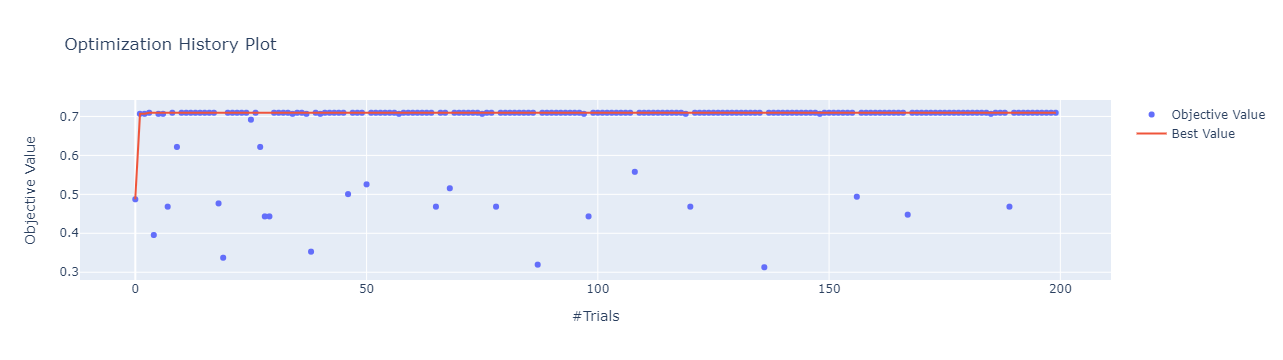

In [176]:
optuna.visualization.plot_optimization_history(study)

In [177]:
print(params)

{'C': 29.957291595018788, 'kernel': 'linear', 'decision_function_shape': 'ovo'}


In [178]:
def objective(trial):
    params = {
        "solver": "saga",
        "max_iter":10000,
        "C": trial.suggest_float("C", 0, 100),
        "penalty": trial.suggest_categorical("penalty",['l1', 'l2', 'elasticnet', 'none'])
    }
    '''
    if params["penalty"] == "l2":
        params["solver"] = 'liblinear',
        params['dual'] = trial.suggest_categorical("dual", [True, False])
    elif params["penalty"] == 'elasticnet':
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0,1)
    '''
    if params["penalty"] == 'elasticnet':
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0,1)

    model = LogisticRegression(**params)
    scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")
    
    return np.mean(scores)

In [179]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
params = study.best_params

[I 2022-05-27 13:10:58,034] A new study created in memory with name: no-name-b0b2de1e-b67c-4dfd-99a5-28b1bd17458f
[I 2022-05-27 13:11:01,804] Trial 0 finished with value: 0.6488888888888888 and parameters: {'C': 15.565858148703315, 'penalty': 'l1'}. Best is trial 0 with value: 0.6488888888888888.
[I 2022-05-27 13:11:05,780] Trial 1 finished with value: 0.6494444444444445 and parameters: {'C': 88.70226828972272, 'penalty': 'elasticnet', 'l1_ratio': 0.041008947668144446}. Best is trial 1 with value: 0.6494444444444445.
[I 2022-05-27 13:11:07,803] Trial 2 finished with value: 0.6494444444444445 and parameters: {'C': 54.46160728501258, 'penalty': 'l2'}. Best is trial 1 with value: 0.6494444444444445.
[I 2022-05-27 13:11:09,662] Trial 3 finished with value: 0.6561111111111111 and parameters: {'C': 25.386052379063884, 'penalty': 'l2'}. Best is trial 3 with value: 0.6561111111111111.
[I 2022-05-27 13:11:11,552] Trial 4 finished with value: 0.6561111111111111 and parameters: {'C': 26.183976903

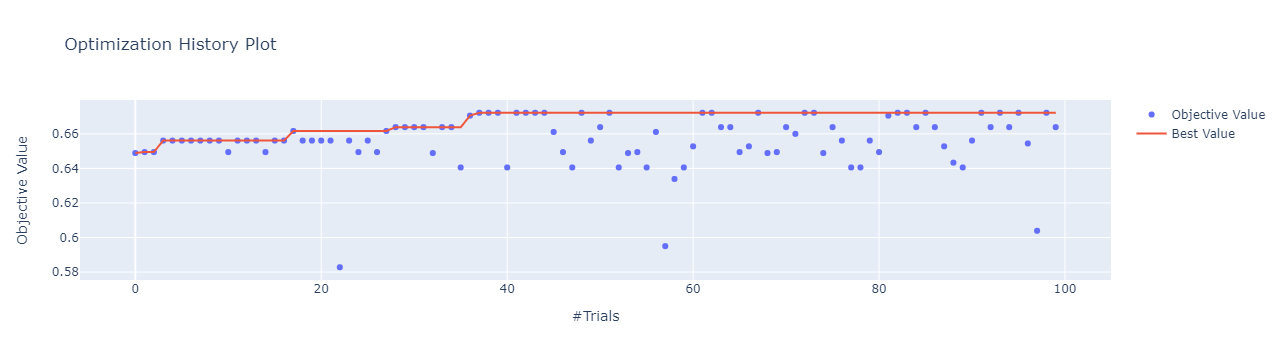

In [180]:
optuna.visualization.plot_optimization_history(study)

In [181]:
print(params)

{'C': 5.76066685312087, 'penalty': 'l1'}


In [182]:
def objective(trial):
    params = {
        "criterion": trial.suggest_categorical("kernel",['gini', 'entropy']),
        "max_depth": trial.suggest_int("max_depth", 2,15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,10),
        "max_features": trial.suggest_categorical("max_features",['auto', 'sqrt', 'log2', None]),
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0, 1.0),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0, 1.0)
    }

    model = DecisionTreeClassifier(**params)
    scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")
    
    return np.mean(scores)

In [183]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)
params = study.best_params

[I 2022-05-27 13:16:51,716] A new study created in memory with name: no-name-f4189adf-c6b8-44dc-9d40-df3047184e0f
[I 2022-05-27 13:16:51,752] Trial 0 finished with value: 0.16666666666666666 and parameters: {'kernel': 'entropy', 'max_depth': 9, 'min_samples_split': 7, 'max_features': None, 'min_impurity_decrease': 0.01984423166407223, 'ccp_alpha': 0.877806984103064}. Best is trial 0 with value: 0.16666666666666666.
[I 2022-05-27 13:16:51,762] Trial 1 finished with value: 0.16666666666666666 and parameters: {'kernel': 'entropy', 'max_depth': 6, 'min_samples_split': 6, 'max_features': 'auto', 'min_impurity_decrease': 0.6904481639664631, 'ccp_alpha': 0.9632561312863039}. Best is trial 0 with value: 0.16666666666666666.
[I 2022-05-27 13:16:51,772] Trial 2 finished with value: 0.16666666666666666 and parameters: {'kernel': 'entropy', 'max_depth': 2, 'min_samples_split': 8, 'max_features': 'sqrt', 'min_impurity_decrease': 0.8035580974270956, 'ccp_alpha': 0.882752112333986}. Best is trial 0 w

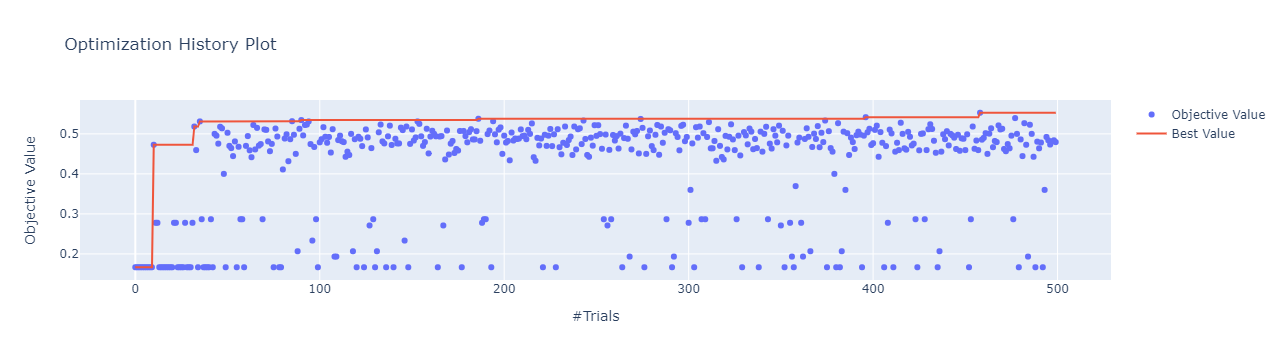

In [184]:
optuna.visualization.plot_optimization_history(study)

In [185]:
print(params)

{'kernel': 'entropy', 'max_depth': 13, 'min_samples_split': 5, 'max_features': None, 'min_impurity_decrease': 0.03448195173892011, 'ccp_alpha': 0.06518408232295814}


## Fit Final Model
- evaluate on hold-out train
- fit a final model on all data

In [231]:
clf = SVC(**{'C': 29.957291595018788, 'kernel': 'linear', 'decision_function_shape': 'ovo'}, probability=True, class_weight='balanced')
clf.fit(X_train, y_train)

SVC(C=29.957291595018788, class_weight='balanced',
    decision_function_shape='ovo', kernel='linear', probability=True)

In [232]:
preds = clf.predict(X_test)

In [233]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      1.00      1.00        51
           2       1.00      0.60      0.75         5
           3       0.94      1.00      0.97        17
           4       0.95      1.00      0.98        20
           5       0.95      0.91      0.93        22

    accuracy                           0.97       127
   macro avg       0.96      0.92      0.93       127
weighted avg       0.97      0.97      0.97       127



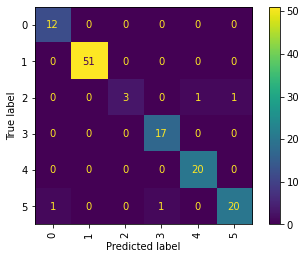

In [234]:
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation='vertical')

In [235]:
final_clf = SVC(**{'C': 29.957291595018788, 'kernel': 'linear', 'decision_function_shape': 'ovo'}, probability=True, class_weight='balanced')
final_clf.fit(X, y)

SVC(C=29.957291595018788, class_weight='balanced',
    decision_function_shape='ovo', kernel='linear', probability=True)

In [236]:
full_train_preds = final_clf.predict(X)

In [237]:
print(classification_report(y, full_train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        21

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



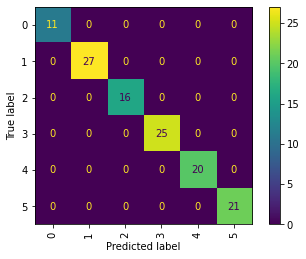

In [238]:
disp = ConfusionMatrixDisplay.from_estimator(final_clf, X, y, xticks_rotation='vertical')

## Create Submission
- read in the test data, create embeddings for it, and featurize it
- do a Pseudo Labelling with high confidence test predictions
- retrain the  final model with augmented data (include psuedo labelled in the train set)
- predict with the final model (final_clf, having been retrained)

In [239]:
def create_features_from_embeddings(embedding_df, dim, cluster_assignments):
    embedding_df['dim']= dim.tolist()
    embedding_df['cluster_assignment'] = cluster_assignments
    cluster_df = pd.crosstab(embedding_df['user'], embedding_df['cluster_assignment'])
    df = pd.DataFrame(embedding_df[['user', 'dim']].groupby('user').agg(np.stack))
    df = df.merge(embedding_df[['user', 'label']], how="left", left_on="user", right_on="user")
    df = df.groupby('user').first().reset_index()
    df = df.merge(cluster_df, how="left", left_on="user", right_on="user")
    
    # Create the distribution based features
    df['mean'] = df['dim'].apply(lambda x : np.mean(x, axis=0))
    df['std'] = df['dim'].apply(lambda x : np.std(x, axis=0))
    df['skew'] = df['dim'].apply(lambda x : skew(x))
    df['kurtosis'] = df['dim'].apply(lambda x : kurtosis(x))
    df['diff_entropy'] = df['dim'].apply(lambda x : differential_entropy(x))
    df['label']= df['label'].astype('category')
    X = df[['mean', 'std', 'skew', 'kurtosis', 'diff_entropy']]
    X = np.array([np.concatenate(i) for i in X.values.tolist()])
    X = np.concatenate([X, df[[0,1,2,3,4,5,6,7,8,9]]], axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = df['label'].cat.codes
    
    return X,y

In [240]:
# Use the same UMAP dim reduction and cluster assignments for the test data

test_dim = training_mapper.transform(np.stack(test_embedding_df['embedding'].values))
test_clusters = cluster_featurizer.predict(np.stack(test_embedding_df['embedding'].values))

In [241]:
X_sub, _ = create_features_from_embeddings(test_embedding_df, test_dim, test_clusters)

Do Pseudo-labelling for some additional training data

(array([106., 453., 453., 334., 260., 173., 123.,  97.,  59.,  37.]),
 array([0.19712439, 0.27584367, 0.35456296, 0.43328224, 0.51200152,
        0.59072081, 0.66944009, 0.74815937, 0.82687865, 0.90559794,
        0.98431722]),
 <BarContainer object of 10 artists>)

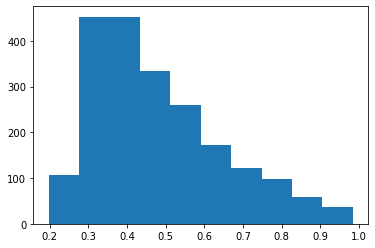

In [242]:
class_probs = final_clf.predict_proba(X_sub)
preds = final_clf.predict(X_sub)

plt.hist(np.max(class_probs,axis=1))

In [243]:
idx_to_add = np.argwhere(np.max(class_probs,axis=1)>0.6).squeeze()

In [244]:
X_aug = np.concatenate((X, X_sub[idx_to_add,:]), axis=0)
y_aug = np.concatenate((y, preds[idx_to_add]), axis=0)

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, stratify=y_aug)

In [246]:
# Look at socring with simple decision tree model with some regularization
cross_val_score(DecisionTreeClassifier(min_samples_leaf=5, max_depth =10), X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")

array([0.68222822, 0.52020412, 0.51115959, 0.67857143, 0.5327381 ])

In [247]:
# look at logistic regression (linear model) with regularization
cross_val_score(LogisticRegression(penalty='elasticnet', l1_ratio=0.3, solver='saga', max_iter=500), X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

Z:\Users\Iain\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



array([0.83878968, 0.85939964, 0.8574122 , 0.89930556, 0.81944444])

In [248]:
# look at logistic regression with regularization and different kernels
cross_val_score(SVC(kernel='rbf', gamma='scale', C=20.0, class_weight='balanced'), X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")

array([0.83292959, 0.86237583, 0.89404223, 0.92906746, 0.83630952])

In [249]:
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 0, 100),
        "kernel": trial.suggest_categorical("kernel",['linear', 'poly', 'rbf', 'sigmoid']),
        "decision_function_shape": trial.suggest_categorical("decision_function_shape", ['ovo','ovr']),
    }
    
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
    elif params["kernel"] in ["rbf", "sigmoid"]:
        params["gamma"] = trial.suggest_categorical("gamma", ['scale', 'auto'])

    model = SVC(**params)
    scores = cross_val_score(model, X_aug, y_aug, cv=StratifiedKFold(n_splits=5), scoring="balanced_accuracy")
    
    return np.mean(scores)

In [250]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400)
params = study.best_params

[I 2022-05-27 13:42:44,131] A new study created in memory with name: no-name-9ada7251-c96c-4f99-b553-f90c46659ce4
[I 2022-05-27 13:42:44,168] Trial 0 finished with value: 0.9081311769991014 and parameters: {'C': 47.291377515772446, 'kernel': 'linear', 'decision_function_shape': 'ovo'}. Best is trial 0 with value: 0.9081311769991014.
[I 2022-05-27 13:42:44,201] Trial 1 finished with value: 0.9081311769991014 and parameters: {'C': 58.220730358118324, 'kernel': 'linear', 'decision_function_shape': 'ovr'}. Best is trial 0 with value: 0.9081311769991014.
[I 2022-05-27 13:42:44,237] Trial 2 finished with value: 0.9081311769991014 and parameters: {'C': 26.687415857112917, 'kernel': 'linear', 'decision_function_shape': 'ovr'}. Best is trial 0 with value: 0.9081311769991014.
[I 2022-05-27 13:42:44,295] Trial 3 finished with value: 0.7768430432969835 and parameters: {'C': 69.08991089604768, 'kernel': 'poly', 'decision_function_shape': 'ovr', 'degree': 2}. Best is trial 0 with value: 0.9081311769

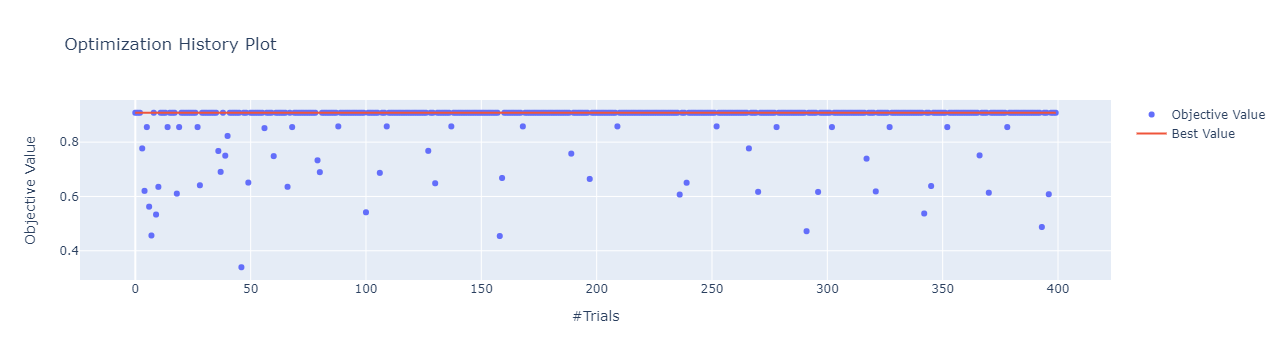

In [251]:
optuna.visualization.plot_optimization_history(study)

In [215]:
print(params)

{'C': 79.98289972025101, 'kernel': 'linear', 'decision_function_shape': 'ovr'}


In [252]:
clf = SVC(**{'C': 79.98289972025101, 'kernel': 'linear', 'decision_function_shape': 'ovr'}, probability=True, class_weight='balanced')
clf.fit(X_train, y_train)

SVC(C=79.98289972025101, class_weight='balanced', kernel='linear',
    probability=True)

In [253]:
preds = clf.predict(X_test)

In [254]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       1.00      1.00      1.00        53
           2       1.00      0.60      0.75         5
           3       0.94      1.00      0.97        15
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        20

    accuracy                           0.97       118
   macro avg       0.96      0.91      0.93       118
weighted avg       0.98      0.97      0.97       118



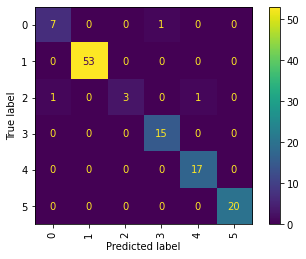

In [255]:
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation='vertical')

In [256]:
sub_clf = SVC(**{'C': 79.98289972025101, 'kernel': 'linear', 'decision_function_shape': 'ovr'}, probability=True, class_weight='balanced')
sub_clf.fit(X_aug, y_aug)

SVC(C=79.98289972025101, class_weight='balanced', kernel='linear',
    probability=True)

In [257]:
full_train_preds = sub_clf.predict(X)

In [258]:
print(classification_report(y, full_train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        21

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



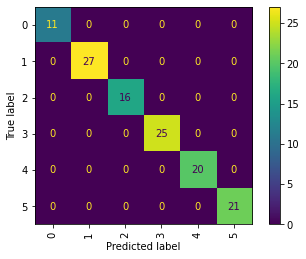

In [259]:
disp = ConfusionMatrixDisplay.from_estimator(sub_clf, X, y, xticks_rotation='vertical')

Make the submission

In [260]:
# Make Predictions on the test data set

submission = sub_clf.predict(X_sub)

In [261]:
campaign_codes

{0: 'china_2019.sample',
 1: 'congress.sample',
 2: 'iranian_2018.sample',
 3: 'political_images.sample',
 4: 'russia_2018.sample',
 5: 'venezuela_2019.sample'}

In [262]:
submission_df = pd.DataFrame(test_embedding_df.groupby('user').first().reset_index()['user'].values, columns=['user_id'])

In [263]:
submission_df['authentic'] = submission
submission_df['authentic'] = submission_df['authentic'].apply(lambda x: 0 if x in [0,2,4,5] else 1)
submission_df['campaign'] = submission
submission_df['campaign'] = submission_df['campaign'].map({0: 'campaign.china_2019', 1: 'None', 2: 'campaign.iranian_2018', 3: 'None',
                                                           4: 'campaign.russia_2018', 5: 'campaign.venezuela_2019'})

In [264]:
submission_df.to_csv("run.csv", index=False)